<ipython-input-2-3aa69c44b55a>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
Clipping input data to th

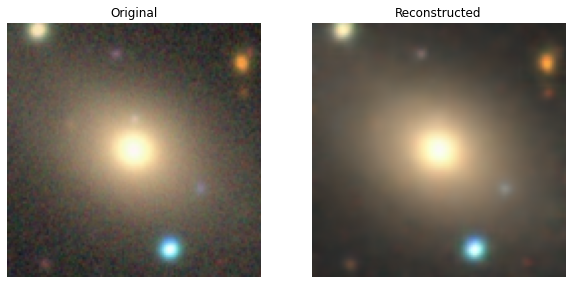

Reconstruction saved to ./results/single_recon.png


In [2]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import glob

# 参数配置
MODEL_PATH = "./models/autoencoder_final.pth"
IMAGE_PATHS = glob.glob("/home/amax/ljm/DATA/Desi_galaxyzoo2_fits/DATA/DATAdesi/jpg/1/*.jpg")
if not IMAGE_PATHS:
    raise FileNotFoundError("No JPG images found in the data path.")
IMAGE_PATH = IMAGE_PATHS[3]
RESULT_PATH = "./results/single_recon.png"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 图像转换操作
transform = transforms.Compose([
    transforms.CenterCrop(152),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# 加载模型
from model import Autoencoder  # 确保导入你的Autoencoder类
model = Autoencoder(latent_dim=128).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

# 加载并预处理图像
image = Image.open(IMAGE_PATH).convert('RGB')
x = transform(image).unsqueeze(0).to(device)

# 推理
with torch.no_grad():
    recon_x, _ = model(x)  # 假设你的模型返回的是重建图像和潜在变量z
    recon_x = recon_x.cpu()

# 可视化
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(x[0].cpu().permute(1, 2, 0).numpy())
plt.title("Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(recon_x[0].cpu().permute(1, 2, 0).numpy())
plt.title("Reconstructed")
plt.axis('off')

plt.savefig(RESULT_PATH, bbox_inches='tight', dpi=150)
plt.show()
print(f"Reconstruction saved to {RESULT_PATH}")

Extracting latent representations...


<ipython-input-4-642550f10bd5>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=device))


Latent features shape: (3000, 128)
Performing dimensionality reduction...


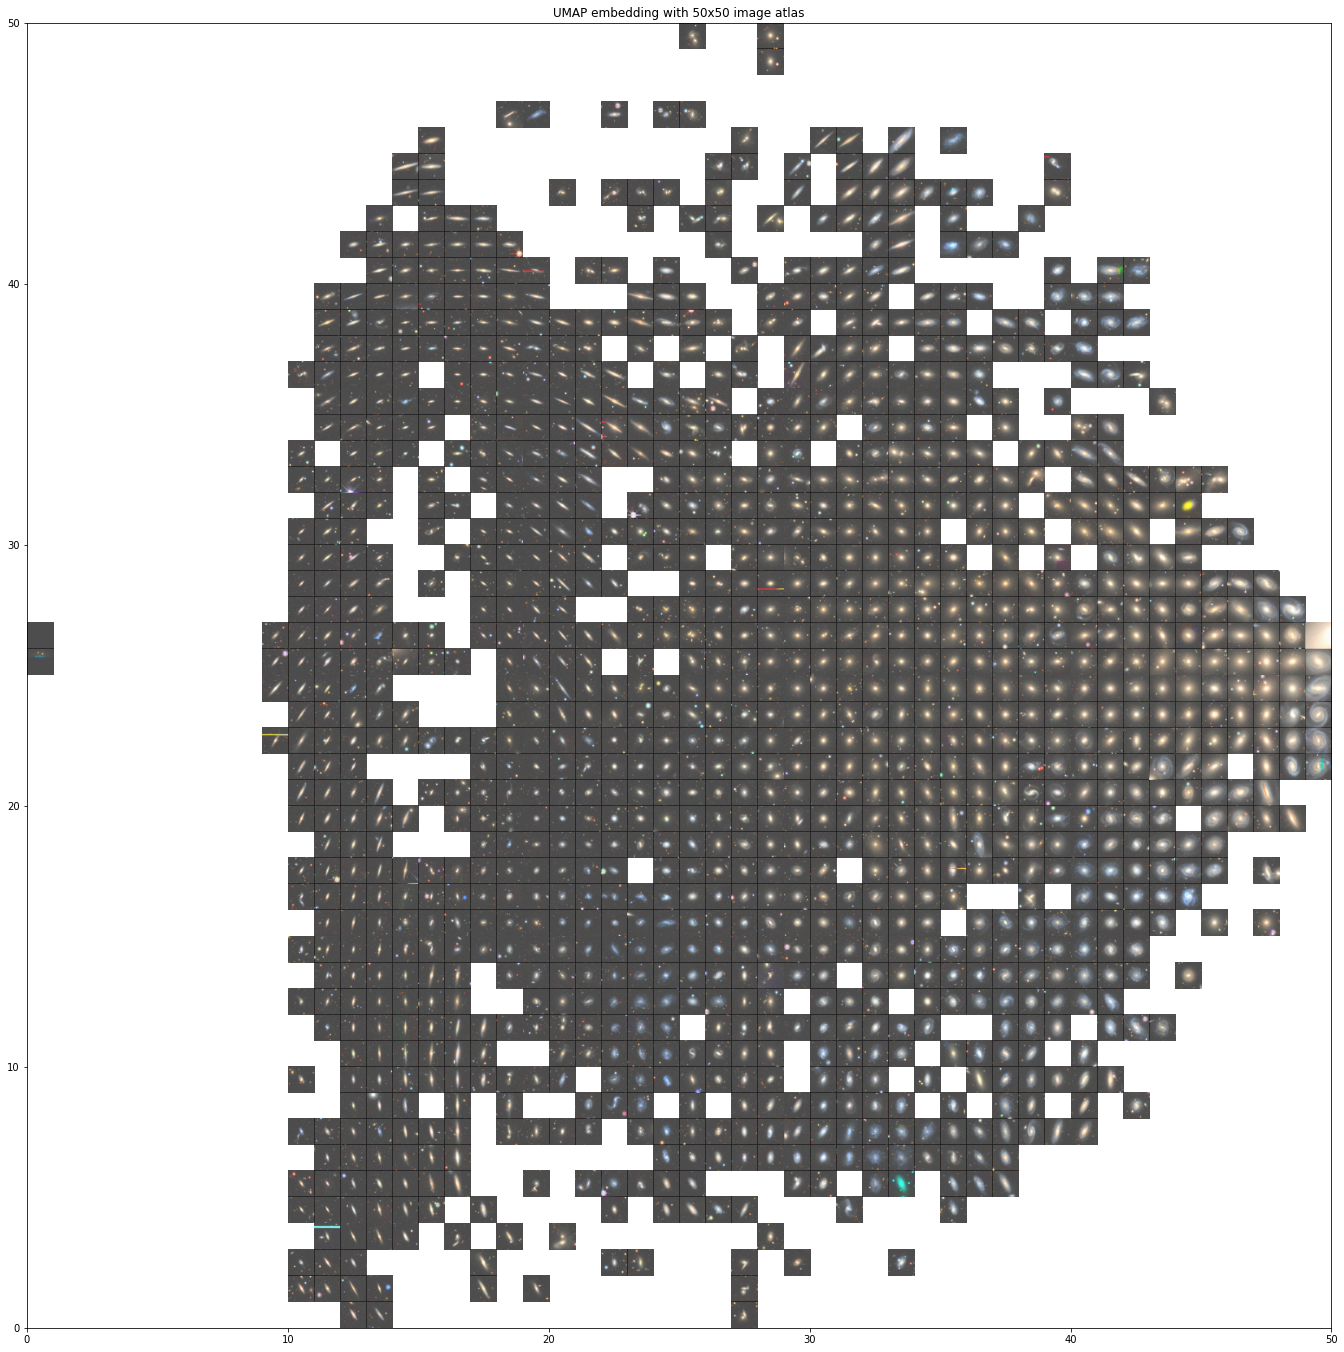

✅ 图像 UMAP 图保存到: ./umap_results/umap_images_50x50.png


<ipython-input-4-642550f10bd5>:143: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], s=10, alpha=0.8, cmap='viridis')


<Figure size 432x288 with 0 Axes>

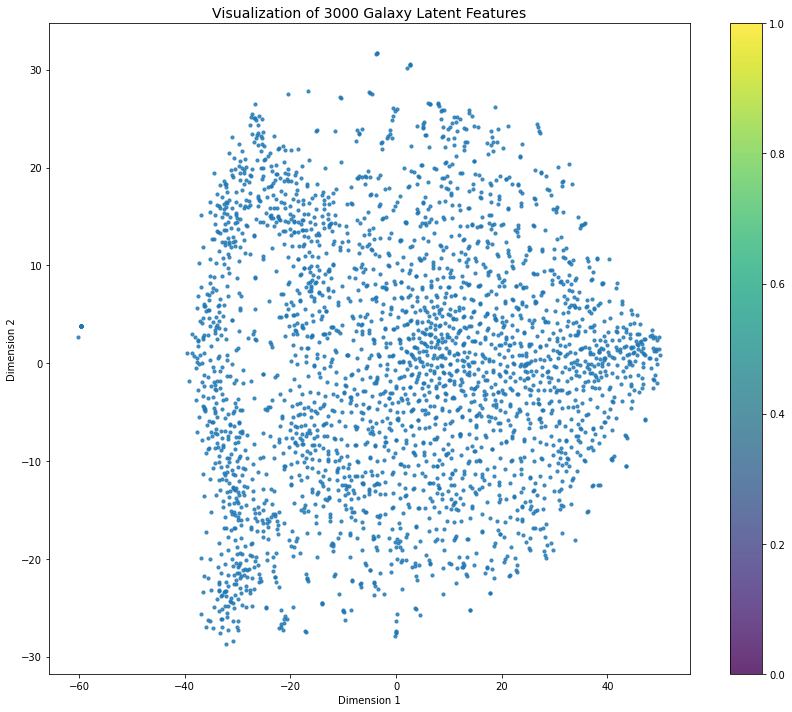

✅ 散点图保存到: ./umap_results/latent_features_scatter.png


In [4]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import glob
import os
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from torch.utils.data import Dataset, DataLoader
from model import Autoencoder

# -------------------------------
# 参数设置
# -------------------------------
MODEL_PATH = "./models/autoencoder_final.pth"
IMAGE_DIR = "/home/amax/ljm/DATA/Desi_galaxyzoo2_fits/DATA/DATAdesi/jpg/1"
RESULT_PLOT_PATH = "./results/tsne_latent_1000.png"
NUM_SAMPLES = 3000
LATENT_DIM = 128
IMG_SIZE = 128
BATCH_SIZE = 64
USE_TSNE = True  
DOWNSAMPLE_FIRST = True  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 图像预处理
transform = transforms.Compose([
    transforms.CenterCrop(152),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

# -------------------------------
# 自定义 Dataset
# -------------------------------
class GalaxyDataset(Dataset):
    def __init__(self, img_paths, transform=None):
        self.img_paths = img_paths
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        path = self.img_paths[idx]
        image = Image.open(path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, path  # 返回图像和文件名（可用于ID）

# -------------------------------
# 加载模型
# -------------------------------
model = Autoencoder(latent_dim=LATENT_DIM).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

# -------------------------------
# 获取图像路径并随机采样
# -------------------------------
all_image_paths = glob.glob(os.path.join(IMAGE_DIR, "*.jpg"))
if len(all_image_paths) < NUM_SAMPLES:
    raise ValueError(f"Not enough images: found {len(all_image_paths)}, need {NUM_SAMPLES}")

# 随机打乱并选1000张
np.random.seed(42)
selected_paths = np.random.choice(all_image_paths, size=NUM_SAMPLES, replace=False)

dataset = GalaxyDataset(selected_paths, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# -------------------------------
# 提取潜在特征
# -------------------------------
latents = []
filenames = []

print("Extracting latent representations...")
with torch.no_grad():
    for x, names in dataloader:
        x = x.to(device)
        z = model.encode(x)  # 假设你的 model 有 .encode() 方法
        latents.append(z.cpu().numpy())
        filenames.extend(names)

latents = np.concatenate(latents, axis=0)  # (1000, 128)
print(f"Latent features shape: {latents.shape}")

# -------------------------------
# 降维：t-SNE 或 PCA
# -------------------------------
print("Performing dimensionality reduction...")
if USE_TSNE:
    reducer = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
    method = "t-SNE"
else:
    reducer = PCA(n_components=2, random_state=42)
    method = "PCA"

latents_2d = reducer.fit_transform(latents)  


def plot_umap_with_images_only(embeddings, filenames, grid_size=50, outdir="./umap_results"):

    os.makedirs(outdir, exist_ok=True)

    # 计算网格坐标
    x = (embeddings[:, 0] - embeddings[:, 0].min()) / (embeddings[:, 0].ptp())
    y = (embeddings[:, 1] - embeddings[:, 1].min()) / (embeddings[:, 1].ptp())
    grid_x = np.floor(x * grid_size).astype(int)
    grid_y = np.floor(y * grid_size).astype(int)

    # 图像 cutout 图
    fig, ax = plt.subplots(figsize=(24, 24))
    ax.set_xlim(0, grid_size)
    ax.set_ylim(0, grid_size)
    ax.set_title(f"UMAP embedding with {grid_size}x{grid_size} image atlas")

    import urllib.request
    from PIL import Image

    for i in range(grid_size):
        for j in range(grid_size):
            idx = np.where((grid_x == i) & (grid_y == j))[0]
            if len(idx) > 0:
                k = idx[0]
                
                filename = filenames[k]

                ax.imshow(Image.open(filename), extent=(i, i+1, j, j+1), alpha=0.8)

    img_file = os.path.join(outdir, f"umap_images_{grid_size}x{grid_size}.png")

    plt.show()
    plt.savefig(img_file, bbox_inches="tight")
    plt.close(fig)
    print(f"✅ 图像 UMAP 图保存到: {img_file}")

    # 绘制降维后的散点图
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], s=10, alpha=0.8, cmap='viridis')

    plt.title(f"Visualization of {NUM_SAMPLES} Galaxy Latent Features", fontsize=14)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.colorbar(scatter)
    plt.tight_layout()
    scatter_plot_file = os.path.join(outdir, "latent_features_scatter.png")
    plt.savefig(scatter_plot_file, dpi=150, bbox_inches='tight')
    plt.show()

    print(f"✅ 散点图保存到: {scatter_plot_file}")


plot_umap_with_images_only(latents_2d,filenames)

<!-- latents
 -->

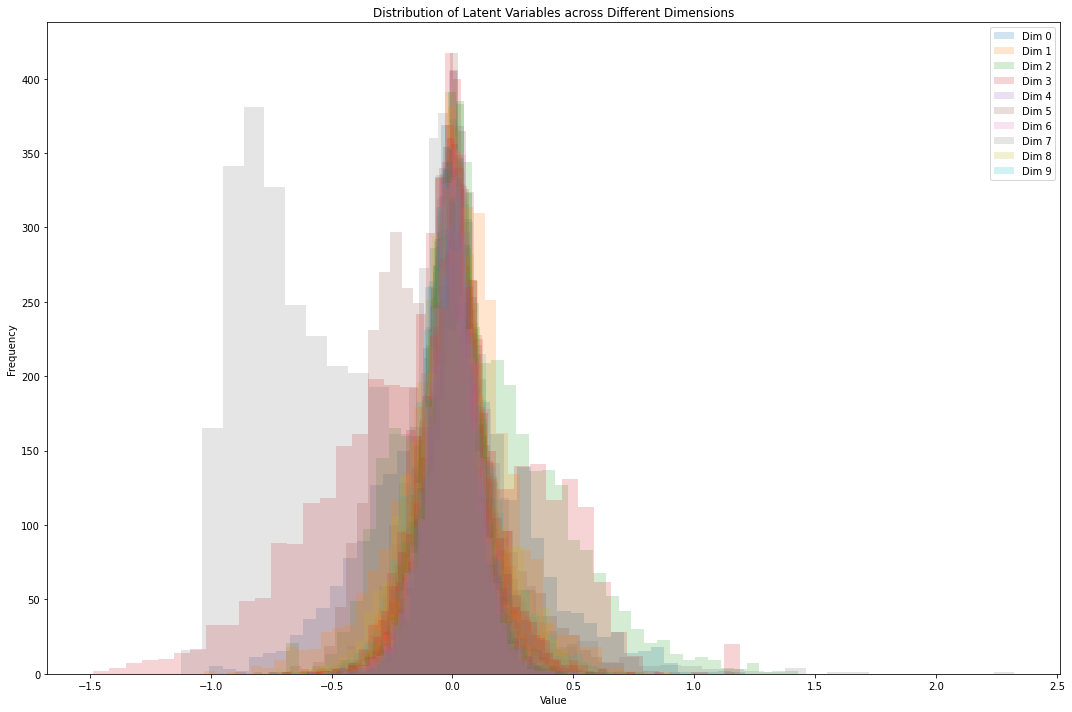

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

for i in range(128): 
    a = [per[i] for per in latents]  # 使用 .item() 获取单个数值
    plt.hist(a, bins=40, alpha=0.2, label=f'Dim {i}' if i < 10 else None)  # 仅前10个维度加标签避免过于杂乱
  
plt.legend()
plt.title('Distribution of Latent Variables across Different Dimensions')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

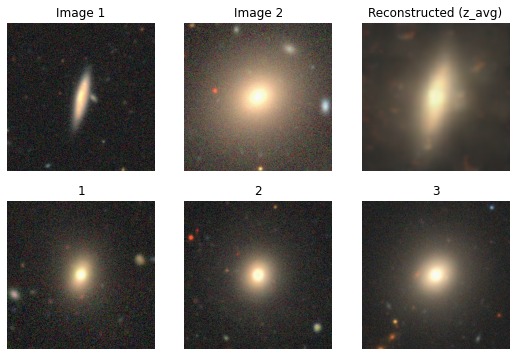

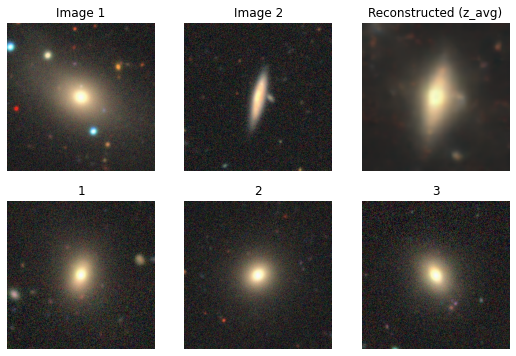

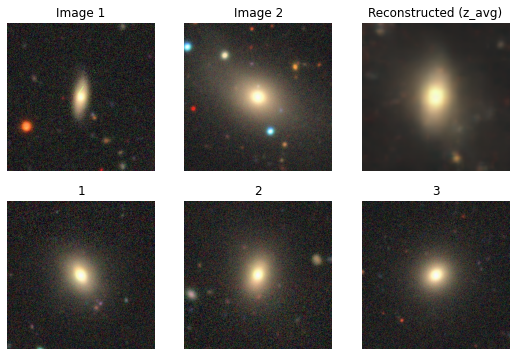

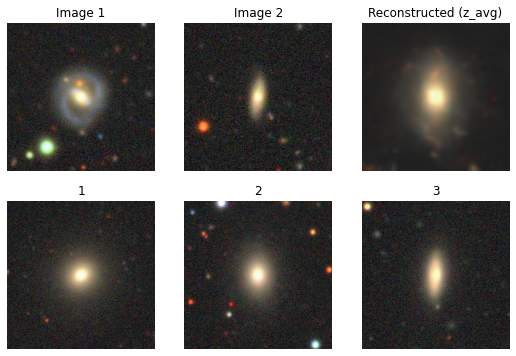

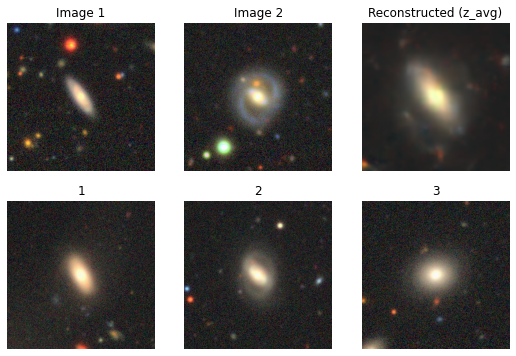

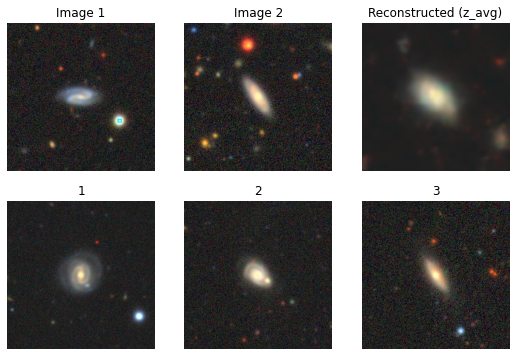

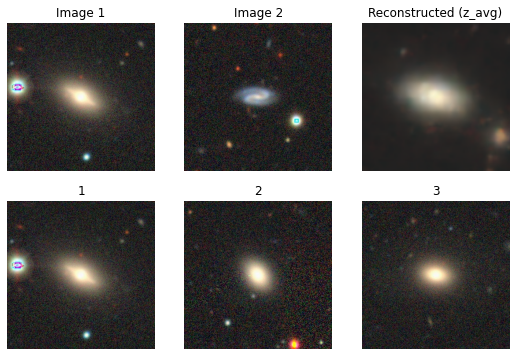

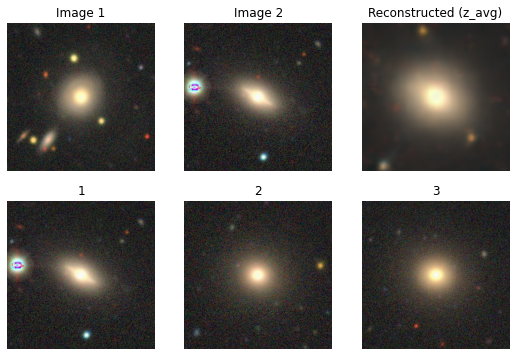

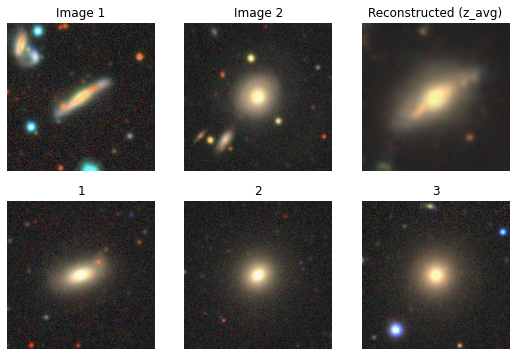

In [ ]:
IMAGE_PATHS = glob.glob("/home/amax/ljm/DATA/Desi_galaxyzoo2_fits/DATA/DATAdesi/jpg/1/*.jpg")
if len(IMAGE_PATHS) < 2:
    raise ValueError("Need at least 2 images for interpolation.")
from scipy.spatial.distance import cdist
import torch

# 确保 latents 是 numpy array，device 正确
latents_np = latents  # shape (N, 128)，前面已提取
latents_tensor = torch.from_numpy(latents_np).to(device)

for i in range(1, 10):
    IMAGE_PATH_1 = IMAGE_PATHS[i+1]
    IMAGE_PATH_2 = IMAGE_PATHS[i]
    RESULT_PATH = f"./results/interpolated_recon_{i}.png"

    def load_and_encode(path):
        image = Image.open(path).convert('RGB')
        x = transform(image).unsqueeze(0).to(device)
        with torch.no_grad():
            z = model.encode(x)
        return z, x, image  # 返回原始 PIL 图像用于显示

    # 编码两张图像
    z1, img1_tensor, img1_pil = load_and_encode(IMAGE_PATH_1)
    z2, img2_tensor, img2_pil = load_and_encode(IMAGE_PATH_2)

    # 插值：取均值
    z_avg = (z1 + z2) / 2  # shape: (1, 128)

    # 解码重建
    with torch.no_grad():
        recon_x = model.decode(z_avg).cpu()
        recon_img = transforms.ToPILImage()(recon_x[0].clamp(0, 1))

    # ---------------------------------------------
    # 🔍 在 latents 中找最接近 z_avg 的真实样本
    # ---------------------------------------------
    z_avg_np = z_avg.cpu().numpy().squeeze()  # shape: (128,)

    # 方法1：使用欧氏距离（推荐）

    distances = np.linalg.norm(latents_np - z_avg_np, axis=1)

    nearest_indices = np.argsort(distances)[:3]  # 获取距离最小的两个索引
    nearest_filenames = [filenames[idx] for idx in nearest_indices]  # 根据索引获取文件名

    nearest_pils = [Image.open(filename).convert('RGB') for filename in nearest_filenames]



    # ---------------------------------------------
    # 🖼️ 可视化：4张图
    # ---------------------------------------------
    plt.figure(figsize=(9, 6))

    # 原图1
    plt.subplot(2, 3, 1)
    plt.imshow(img1_pil)
    plt.title("Image 1")
    plt.axis("off")

    # 原图2
    plt.subplot(2, 3, 2)
    plt.imshow(img2_pil)
    plt.title("Image 2")
    plt.axis("off")

    # 重建的插值图像
    plt.subplot(2, 3, 3)
    plt.imshow(recon_img)
    plt.title("Reconstructed (z_avg)")
    plt.axis("off")

    # 最相似的真实图像
    count = 0
    for nearest_pil in nearest_pils:

        count += 1
        plt.subplot(2, 3, count+3)
        plt.imshow(nearest_pil)
        plt.title(f"{count}")
        plt.axis("off")

    # 保存并显示
    os.makedirs("./results", exist_ok=True)

    plt.show()



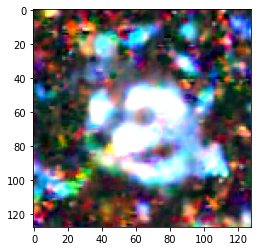

In [ ]:
z_avg = torch.randn(1, 128).to(device)
with torch.no_grad():
    recon_x = model.decode(z_avg).cpu()
    recon_img = transforms.ToPILImage()(recon_x[0].clamp(0, 1))

plt.imshow(recon_img)
plt.show()


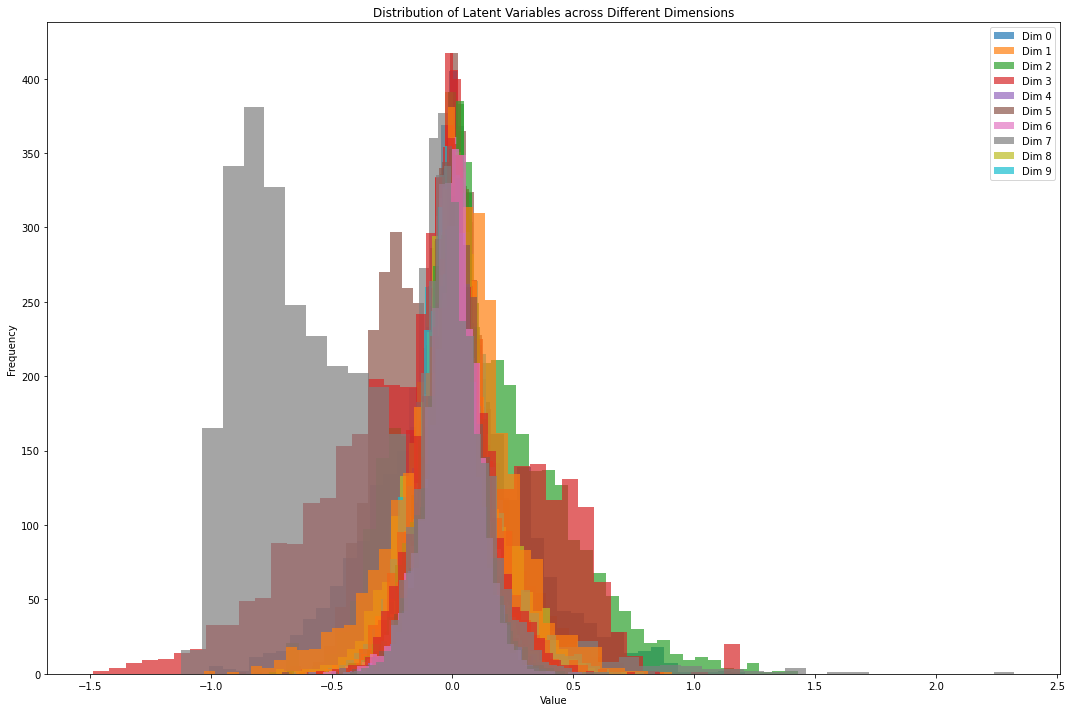

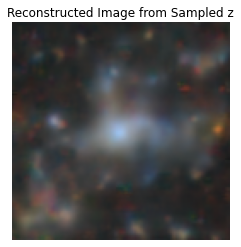

In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms


plt.figure(figsize=(15, 10))

z_sampled = torch.zeros(1, 128)  

for i in range(128):
    dim_values = torch.tensor([per[i].item() for per in latents])  # 转成 PyTorch tensor
    
    plt.hist(dim_values.numpy(), bins=40, alpha=0.7, label=f'Dim {i}' if i < 10 else None)

    idx = torch.randint(low=0, high=len(dim_values), size=(1,))  # 随机索引
    sampled_value = dim_values[idx].item()  

    # ✅ 正确赋值方式：用 .fill_() 或重新构造 tensor
    z_sampled[0, i] = sampled_value  # PyTorch 允许 float -> Tensor 自动转换（标量）

plt.legend()
plt.title('Distribution of Latent Variables across Different Dimensions')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# -------------------------------
# 使用采样得到的 z_sampled 进行重建
# -------------------------------
z_sampled = z_sampled.to(device)  # 移动到模型所在设备

with torch.no_grad():
    recon_x = model.decode(z_sampled).cpu()  # 解码
    recon_img = transforms.ToPILImage()(recon_x[0].clamp(0, 1))  # 转为图像

# 显示重建结果
plt.imshow(recon_img)
plt.title("Reconstructed Image from Sampled z")
plt.axis('off')
plt.show()